This notebook examines the results from three modifications to the previous MESA inlists

* a new set of wind models
* a new stopping condition to avoid runaway critically rotating stars
* tracking the chemical mixing timescale

### Prelude

In [13]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

import astropy.units as u
import astropy.constants as ct
from astropy.cosmology import WMAP9
from scipy.signal import find_peaks
from scipy.integrate import simpson

import mesa_reader as mr

import sys
sys.path.append('..')
from src.constants import (Z_SUN, MASS_U, PERIOD_U, AGE_U, SMA_U, RADIUS_U, TEMP_U, LUMINOSITY_U, 
                           T_H)
from src.star import (eggleton_rl1_radius, marchant_l2_radius, a_from_p, p_from_a, tau_kh, fix_unit,
                      ToutMassLuminosityRelation, ToutMassRadiusRelation, 
                      HurleyMassLuminosityRelation, HurleyMassRadiusRelation)


In [14]:
plt.style.use('./plotstyle.mplstyle')

In [15]:
def tau_es1(m, r, tau_kh, omega):
    m = fix_unit(m, MASS_U)
    r = fix_unit(r, RADIUS_U)
    tau_kh = fix_unit(tau_kh, u.yr)
    omega *= u.s**-1
    tau_es = tau_kh * ct.G * m / (omega**2 * r**3)   
    return tau_es.to(u.yr).value
    

### References

Gottlieb, O., Renzo, M., Metzger, B. D., Goldberg, J. A. & Cantiello, M., *She's got her mother's hair: end-to-end collapsar simulations unveil the origin of black holes' magnetic field*, 2024, [arXiv:2407.16745](https://ui.adsabs.harvard.edu/abs/2024arXiv240716745G/abstract)  
Nugis, T. & Lamers, H. J. G. L. M., *Mass-loss rates of Wolf-Rayet stars as a function of stellar parameters*, 2000, [A&A 360, 227](https://ui.adsabs.harvard.edu/abs/2000A%26A...360..227N/abstract)  
Vink, J. S., de Koter, A. & Lamers, H. J. G. L. M., *New theoretical mass-loss rates of O and B Stars*, 2000, [A&A, 362, 295](https://ui.adsabs.harvard.edu/abs/2000A%26A...362..295V/abstract)

### Definitions

In [16]:
mix_dict = dict(
    crystallized=-1,
    none=0,
    convective=1,
    overshoot=2,
    semiconvective=3,
    thermohaline=4,
    rotation=5,
    rayleigh_taylor=6,
    minimum=7,
    anonymous=8,
    leftover=9,
    phase_sep=10
    )
mix_dict = {v: k for k, v in mix_dict.items()}

In [17]:
def get_model_dict(grid_folder):
    d = dict()
    for model_folder in grid_folder.glob('m*_w*'):
        if model_folder.suffix == '.log':
            continue
        m, w = model_folder.name.replace('d', 'e').split('_')        
        m = f'{float(m.lstrip("m")):.1f}'
        w = float(w.lstrip('w'))
        p = 2*np.pi / w / (60*60*24)
        p = f'{p:.2f}'
        if m not in d.keys():
            d[m] = dict()
        d[m][p] = model_folder
    return d

In [18]:
def monitor(w, h, axes, c, col_indices=[0, 1, 2, 3, 4, 5, 6]):
    #fig, axes = plt.subplots(1, 7, figsize=(36, 4), sharex=True)
    #fig.subplots_adjust(wspace=0.5)

    omg_ax, wct_ax, vrt_ax, mss_ax, rad_ax, lum_ax, he4_ax = col_indices 

    axes[omg_ax].plot(h.star_age/1e6, h.surf_avg_v_rot/(2*np.pi*h.radius*u.Rsun.to(u.km)/(2*np.pi)), lw=1, c=c)     
    axes[vrt_ax].plot(h.star_age/1e6, h.surf_avg_v_rot, lw=1, c=c)     
    axes[rad_ax].plot(h.star_age/1e6, h.radius, lw=1, c=c)    
    axes[wct_ax].plot(h.star_age/1e6, h.surf_avg_omega_div_omega_crit, lw=1, c=c)        
    axes[mss_ax].plot(h.star_age/1e6, h.star_mass, lw=1, c=c)    
    axes[lum_ax].plot(h.star_age/1e6, h.log_L, lw=1, c=c)    
    axes[he4_ax].plot(h.star_age/1e6, h.surface_he4, lw=1, c=c)    
    axes[he4_ax].plot(h.star_age/1e6, h.center_h1, lw=1, c=c, ls='--') 
    
    i_critrot_peaks = find_peaks(h.surf_avg_omega_div_omega_crit, height=1, distance=100, prominence=0.1)[0]
    t_critrot_peaks= h.star_age[i_critrot_peaks]/1e6
    for t in t_critrot_peaks:
        # don't plot peaks (too many in one panel)
        continue
        for ax in axes:
            y0, y1 = ax.get_ylim()
            ax.vlines(t, 0, y1, lw=1, color='k', ls='-')
            try:
                ax.vlines(h.star_age[1500]/1e6, 0, y1, lw=1, color='k', ls='--')
            except IndexError:
                pass
            ax.set_ylim(y0, y1)
            
    #axes[omg_ax].set_ylabel('$\\Omega$')
    #axes[vrt_ax].set_ylabel('$v_\\mathrm{rot}/\\mathrm{km}\\,\\mathrm{s}^{-1}$')
    #axes[rad_ax].set_ylabel('$R/\\mathrm{R}_\\odot$')
    #axes[wct_ax].set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
    #axes[mss_ax].set_ylabel('$M/\\mathrm{M}_\\odot$')
    #axes[lum_ax].set_ylabel('$L/\\mathrm{L}_\\odot$')
    #axes[he4_ax].set_ylabel('S.He4 / C. H1')
    
    if h.center_h1[-1] < 1e-7:
        status = 'DONE'
    else:
        status = 'RUNNING'
        
    p = 2 * np.pi / float(w) / (24*60*60)
    handle = Line2D((-1, -1), (-1, -1), linestyle='-', color=c, 
                    label=f'${p:.2f}\\,\\mathrm{{d}}$ ({np.log10(h.center_h1[-1]):.1f}, {len(h.star_age)} steps)')
    #axes[3].text(0.5, 1.1, f'$m={m:.1f}\\,\\mathrm{{M}}_\\odot, P={p:.2f}\\,\\mathrm{{d}}, \\Omega={w:.1e}\\,\\mathrm{{rad}}\\,\\mathrm{{s}}^{{-1}},$ {len(h.star_age)} steps ({status})', 
    #             rotation=0, va='center', ha='right', fontsize=28, transform=axes[3].transAxes)   
    
    return axes, handle

### Analysis

In [40]:
ROOT = Path.cwd().parent
GRID_FOLDER = ROOT/'mesa/sse_che_window_test/new_models_test'

In [41]:
model_dict = get_model_dict(GRID_FOLDER)
model_dict

{'180.0': {'4.04': PosixPath('/mnt/home/ldesa/repos/cher/mesa/sse_che_window_test/new_models_test/m1.8d+02_w1.8d-05')},
 '39.0': {'1.28': PosixPath('/mnt/home/ldesa/repos/cher/mesa/sse_che_window_test/new_models_test/m3.9d+01_w5.7d-05'),
  '0.89': PosixPath('/mnt/home/ldesa/repos/cher/mesa/sse_che_window_test/new_models_test/m3.9d+01_w8.2d-05')},
 '65.0': {'1.65': PosixPath('/mnt/home/ldesa/repos/cher/mesa/sse_che_window_test/new_models_test/m6.5d+01_w4.4d-05'),
  '2.80': PosixPath('/mnt/home/ldesa/repos/cher/mesa/sse_che_window_test/new_models_test/m6.5d+01_w2.6d-05')},
 '14.0': {'0.48': PosixPath('/mnt/home/ldesa/repos/cher/mesa/sse_che_window_test/new_models_test/m1.4d+01_w1.5d-04')}}

/tmp/ipykernel_2936798/3378592611.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_keys_sort = np.argsort(np.float64(np.array(list(p_dict.keys()))))


(3.0, 6.930330054722858)

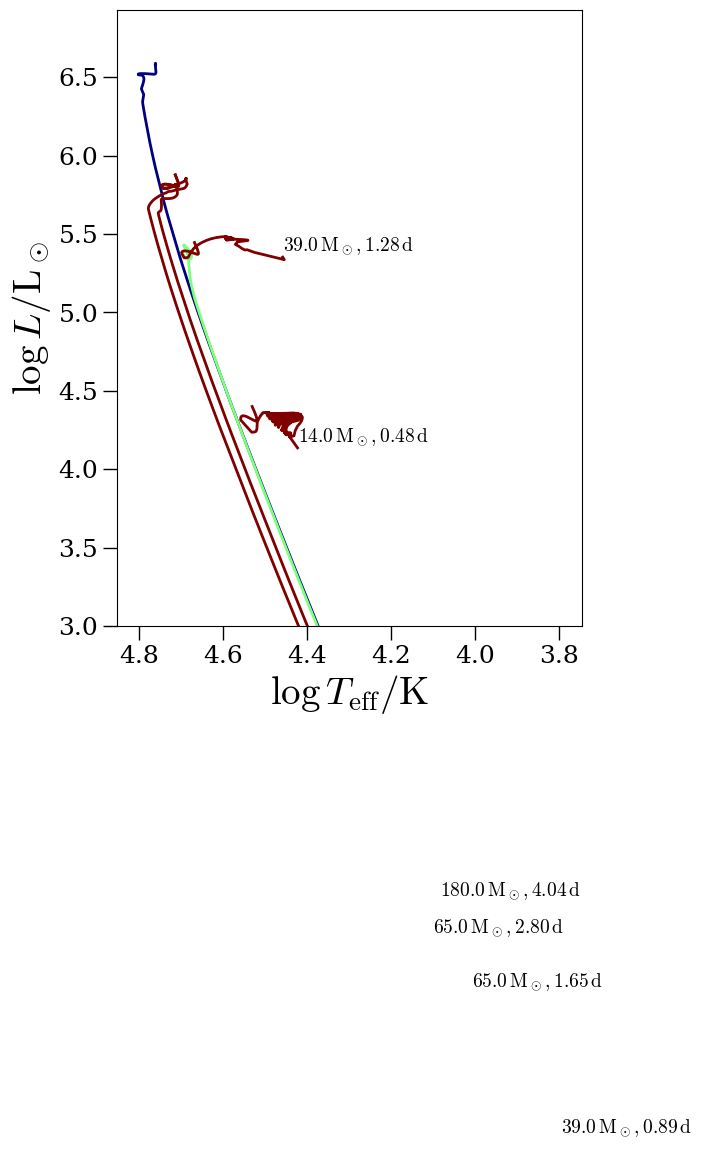

In [49]:
fig, ax = plt.subplots(figsize=(6, 8))

i = 0
for m_key in model_dict.keys():
    p_dict = model_dict[m_key]
    p_keys_sort = np.argsort(np.float64(np.array(list(p_dict.keys()))))
    p_keys = np.array(list(p_dict.keys()))[p_keys_sort]
    m = float(m_key)
    handles = []
    for p_key in p_keys:
        p = float(p_key)
        model_path = p_dict[p_key]
        h = mr.MesaData(str(model_path/'LOGS/history.data'))
        #ax.scatter(h.log_Teff, h.log_L, c=h.surface_he4)
        ax.plot(h.log_Teff, h.log_L, color=cm.jet(i/len(p_keys)))
        ax.text(h.log_Teff[-1], h.log_L[-1], f'${m:.1f}\\,\\mathrm{{M}}_\\odot,{p:.2f}\\,\\mathrm{{d}}$',
                ha='left', va='bottom', transform=ax.transData, fontsize=14)
        i += 1
            
ax.invert_xaxis()
ax.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')
ax.set_ylabel('$\\log L/\\mathrm{L}_\\odot$')
ax.set_ylim(3)

/tmp/ipykernel_2936798/187645760.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_keys_sort = np.argsort(np.float64(np.array(list(p_dict.keys()))))


Text(0, 0.5, '$\\dot{M}$ timescale')

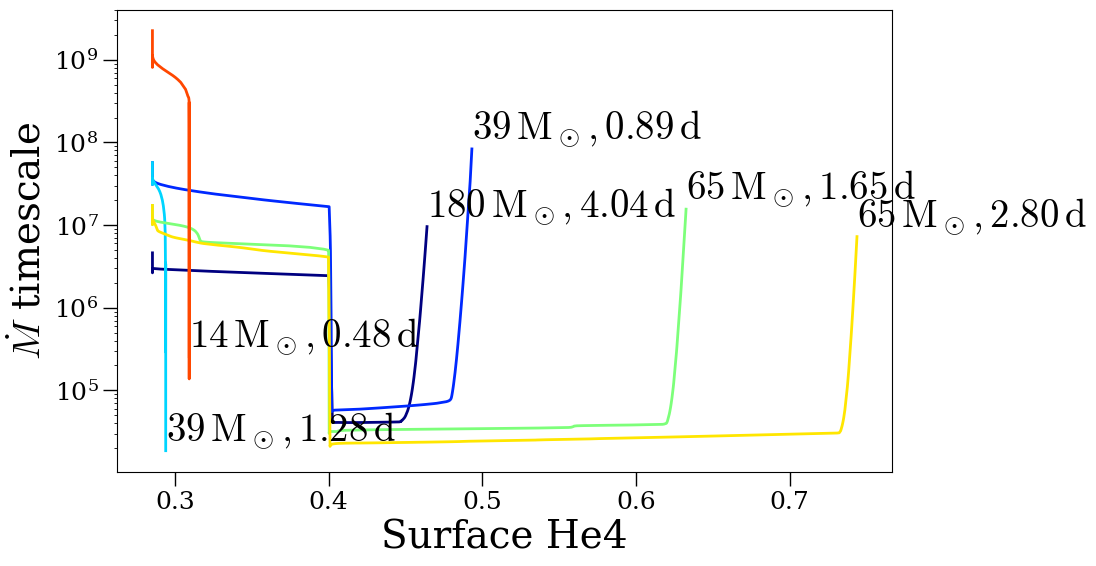

In [52]:
fig, ax = plt.subplots(figsize=(10, 6))

i = 0
for m_key in model_dict.keys():
    p_dict = model_dict[m_key]
    p_keys_sort = np.argsort(np.float64(np.array(list(p_dict.keys()))))
    p_keys = np.array(list(p_dict.keys()))[p_keys_sort]
    m = float(m_key)
    handles = []
    for p_key in p_keys:
        p = float(p_key)
        model_path = p_dict[p_key]
        h = mr.MesaData(str(model_path/'LOGS/history.data'))
        #ax.scatter(h.log_Teff, h.log_L, c=h.surface_he4)
        ax.plot(h.surface_he4, h.mdot_timescale, color=cm.jet(i/len(all_paths)))
        ax.text(h.surface_he4[-1], h.mdot_timescale[-1], f'${m:.0f}\\,\\mathrm{{M}}_\\odot,{p:.2f}\\,\\mathrm{{d}}$',
                ha='left', va='bottom', transform=ax.transData)
        i += 1
ax.set_yscale('log')
            
ax.set_xlabel('Surface He4')
ax.set_ylabel('$\dot{M}$ timescale')

/tmp/ipykernel_2936798/420389667.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_keys_sort = np.argsort(np.float64(np.array(list(p_dict.keys()))))
/tmp/ipykernel_2936798/420389667.py:15: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(h.surf_avg_omega_div_omega_crit), h.mdot_timescale, color=cm.jet(i/len(all_paths)))
/tmp/ipykernel_2936798/420389667.py:16: RuntimeWarning: divide by zero encountered in log10
  ax.text(np.log10(h.surf_avg_omega_div_omega_crit)[-1], h.mdot_timescale[-1], f'${m:.0f}\\,\\mathrm{{M}}_\\odot,{p:.2f}\\,\\mathrm{{d}}$',


Text(0, 0.5, '$\\dot{M}$ timescale')

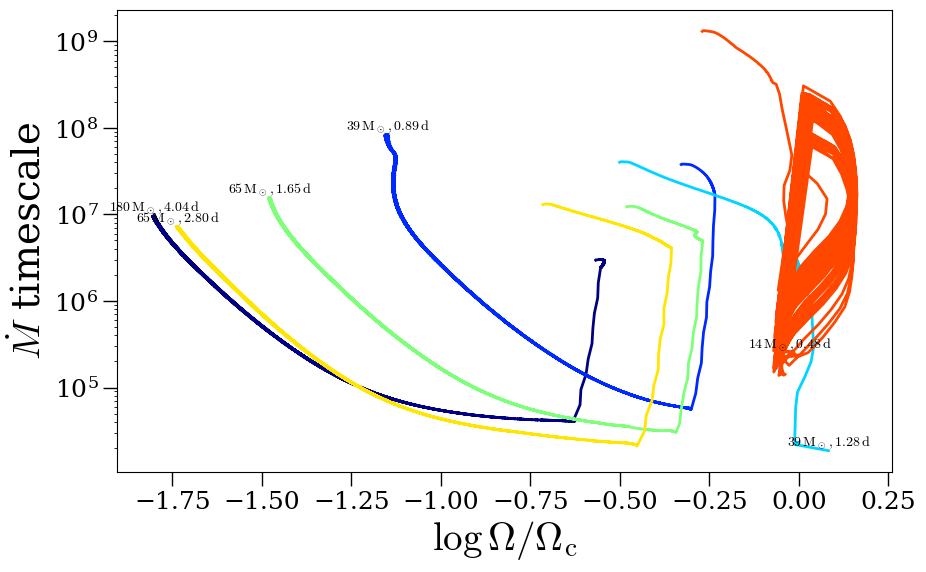

In [55]:
fig, ax = plt.subplots(figsize=(10, 6))

i = 0
for m_key in model_dict.keys():
    p_dict = model_dict[m_key]
    p_keys_sort = np.argsort(np.float64(np.array(list(p_dict.keys()))))
    p_keys = np.array(list(p_dict.keys()))[p_keys_sort]
    m = float(m_key)
    handles = []
    for p_key in p_keys:
        p = float(p_key)
        model_path = p_dict[p_key]
        h = mr.MesaData(str(model_path/'LOGS/history.data'))
        #ax.scatter(h.log_Teff, h.log_L, c=h.surface_he4)
        ax.plot(np.log10(h.surf_avg_omega_div_omega_crit), h.mdot_timescale, color=cm.jet(i/len(all_paths)))
        ax.text(np.log10(h.surf_avg_omega_div_omega_crit)[-1], h.mdot_timescale[-1], f'${m:.0f}\\,\\mathrm{{M}}_\\odot,{p:.2f}\\,\\mathrm{{d}}$',
                ha='center', va='bottom', transform=ax.transData, fontsize=10)
        i += 1
ax.set_yscale('log')
            
ax.set_xlabel('$\\log \\Omega/\\Omega_\\mathrm{c}$')
ax.set_ylabel('$\dot{M}$ timescale')

/tmp/ipykernel_2936798/1046132738.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_keys_sort = np.argsort(np.float64(np.array(list(p_dict.keys()))))


Text(0, 0.5, '$\\dot{M}$ timescale')

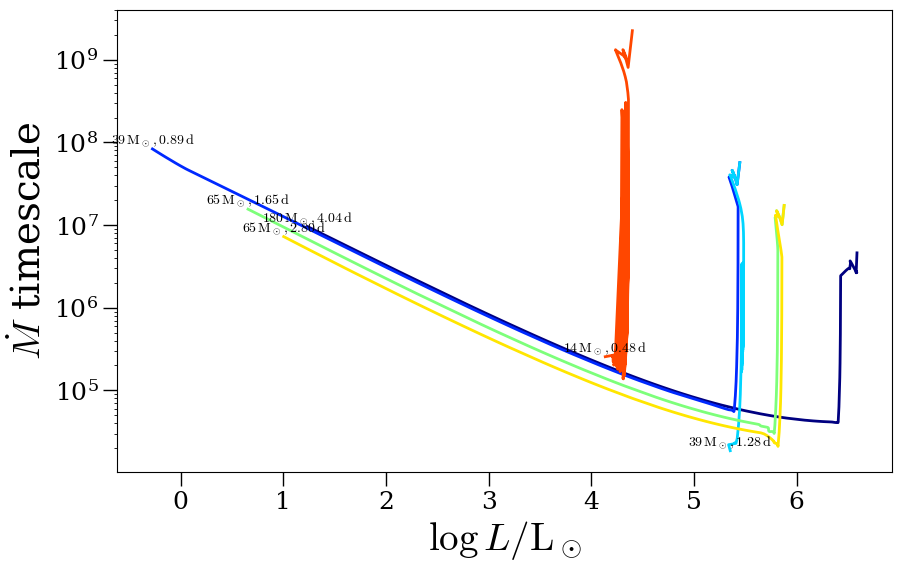

In [58]:
fig, ax = plt.subplots(figsize=(10, 6))

i = 0
for m_key in model_dict.keys():
    p_dict = model_dict[m_key]
    p_keys_sort = np.argsort(np.float64(np.array(list(p_dict.keys()))))
    p_keys = np.array(list(p_dict.keys()))[p_keys_sort]
    m = float(m_key)
    handles = []
    for p_key in p_keys:
        p = float(p_key)
        model_path = p_dict[p_key]
        h = mr.MesaData(str(model_path/'LOGS/history.data'))
        #ax.scatter(h.log_Teff, h.log_L, c=h.surface_he4)
        ax.plot(h.log_L, h.mdot_timescale, color=cm.jet(i/len(all_paths)))
        ax.text(h.log_L[-1], h.mdot_timescale[-1], f'${m:.0f}\\,\\mathrm{{M}}_\\odot,{p:.2f}\\,\\mathrm{{d}}$',
                ha='center', va='bottom', transform=ax.transData, fontsize=10)
        i += 1
ax.set_yscale('log')
            
ax.set_xlabel('$\\log L/\\mathrm{L}_\\odot$')
ax.set_ylabel('$\dot{M}$ timescale')

/tmp/ipykernel_2936798/4008043673.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_keys_sort = np.argsort(np.float64(np.array(list(p_dict.keys()))))


Text(0, 0.5, '$\\dot{M}$ timescale')

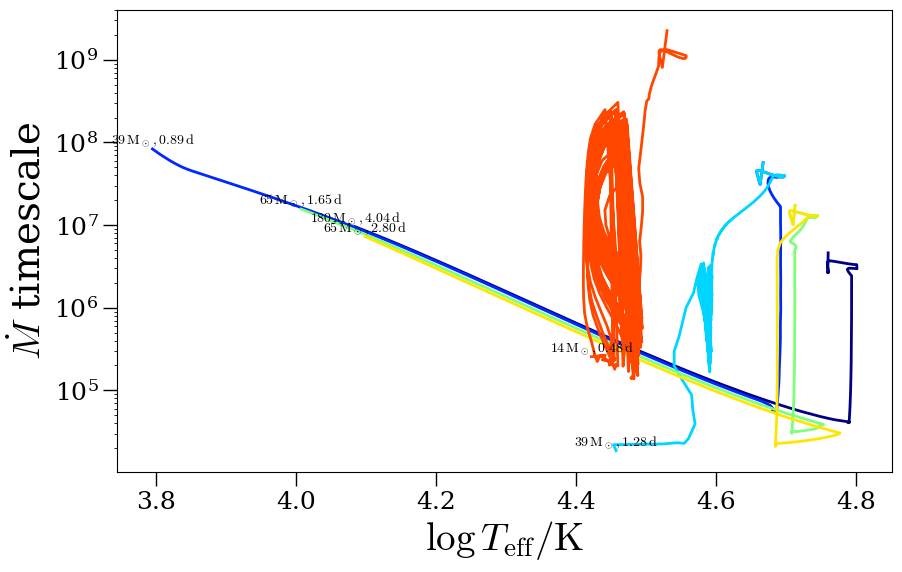

In [59]:
fig, ax = plt.subplots(figsize=(10, 6))

i = 0
for m_key in model_dict.keys():
    p_dict = model_dict[m_key]
    p_keys_sort = np.argsort(np.float64(np.array(list(p_dict.keys()))))
    p_keys = np.array(list(p_dict.keys()))[p_keys_sort]
    m = float(m_key)
    handles = []
    for p_key in p_keys:
        p = float(p_key)
        model_path = p_dict[p_key]
        h = mr.MesaData(str(model_path/'LOGS/history.data'))
        #ax.scatter(h.log_Teff, h.log_L, c=h.surface_he4)
        ax.plot(h.log_Teff, h.mdot_timescale, color=cm.jet(i/len(all_paths)))
        ax.text(h.log_Teff[-1], h.mdot_timescale[-1], f'${m:.0f}\\,\\mathrm{{M}}_\\odot,{p:.2f}\\,\\mathrm{{d}}$',
                ha='center', va='bottom', transform=ax.transData, fontsize=10)
        i += 1
ax.set_yscale('log')
            
ax.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')
ax.set_ylabel('$\dot{M}$ timescale')

/tmp/ipykernel_2936798/755726795.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_keys_sort = np.argsort(np.float64(np.array(list(p_dict.keys()))))
/tmp/ipykernel_2936798/755726795.py:15: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(h.surf_avg_omega_div_omega_crit), h.mdot_timescale, color=cm.jet(i/len(all_paths)))
/tmp/ipykernel_2936798/755726795.py:16: RuntimeWarning: divide by zero encountered in log10
  ax.text(np.log10(h.surf_avg_omega_div_omega_crit)[-1], h.mdot_timescale[-1], f'${m:.0f}\\,\\mathrm{{M}}_\\odot,{p:.2f}\\,\\mathrm{{d}}$',


Text(0, 0.5, '$\\dot{M}$ timescale')

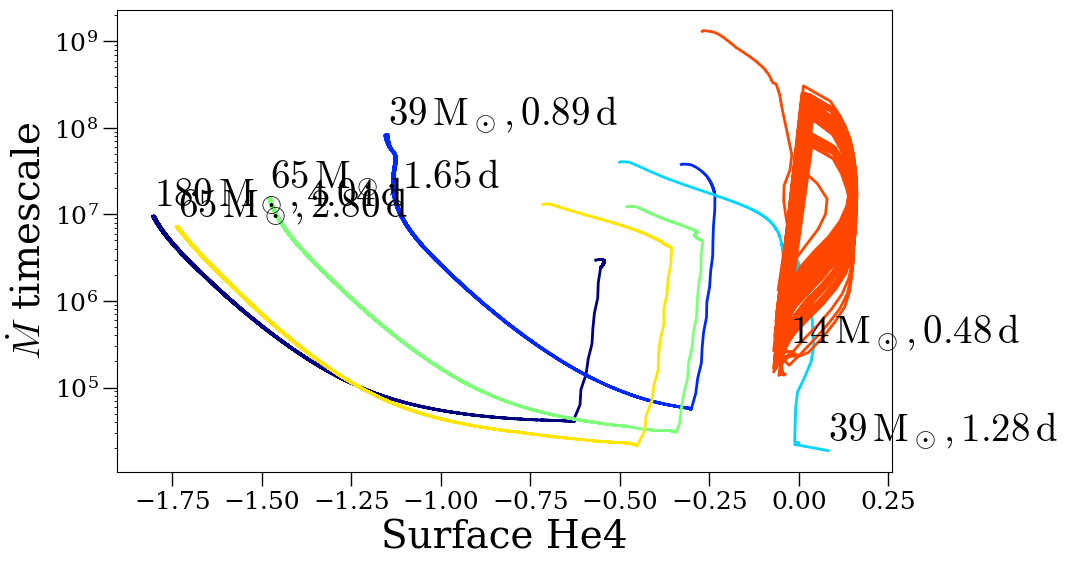

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

i = 0
for m_key in model_dict.keys():
    p_dict = model_dict[m_key]
    p_keys_sort = np.argsort(np.float64(np.array(list(p_dict.keys()))))
    p_keys = np.array(list(p_dict.keys()))[p_keys_sort]
    m = float(m_key)
    handles = []
    for p_key in p_keys:
        p = float(p_key)
        model_path = p_dict[p_key]
        h = mr.MesaData(str(model_path/'LOGS/history.data'))
        #ax.scatter(h.log_Teff, h.log_L, c=h.surface_he4)
        ax.plot(np.log10(h.surf_avg_omega_div_omega_crit), h.mdot_timescale, color=cm.jet(i/len(all_paths)))
        ax.text(np.log10(h.surf_avg_omega_div_omega_crit)[0], h.mdot_timescale[0], f'${m:.0f}\\,\\mathrm{{M}}_\\odot,{p:.2f}\\,\\mathrm{{d}}$',
                ha='center', va='bottom', transform=ax.transData, fontsize=10)
        i += 1
ax.set_yscale('log')
            
ax.set_xlabel('$\\log \\Omega/\\Omega_\\mathrm{c}$')
ax.set_ylabel('$\dot{M}$ timescale')

In [21]:
test_case = model_dict['39.0']['1.28']

In [22]:
logs  = mr.MesaLogDir(str(test_case/'LOGS'))

In [23]:
profile_numbers = logs.profile_numbers

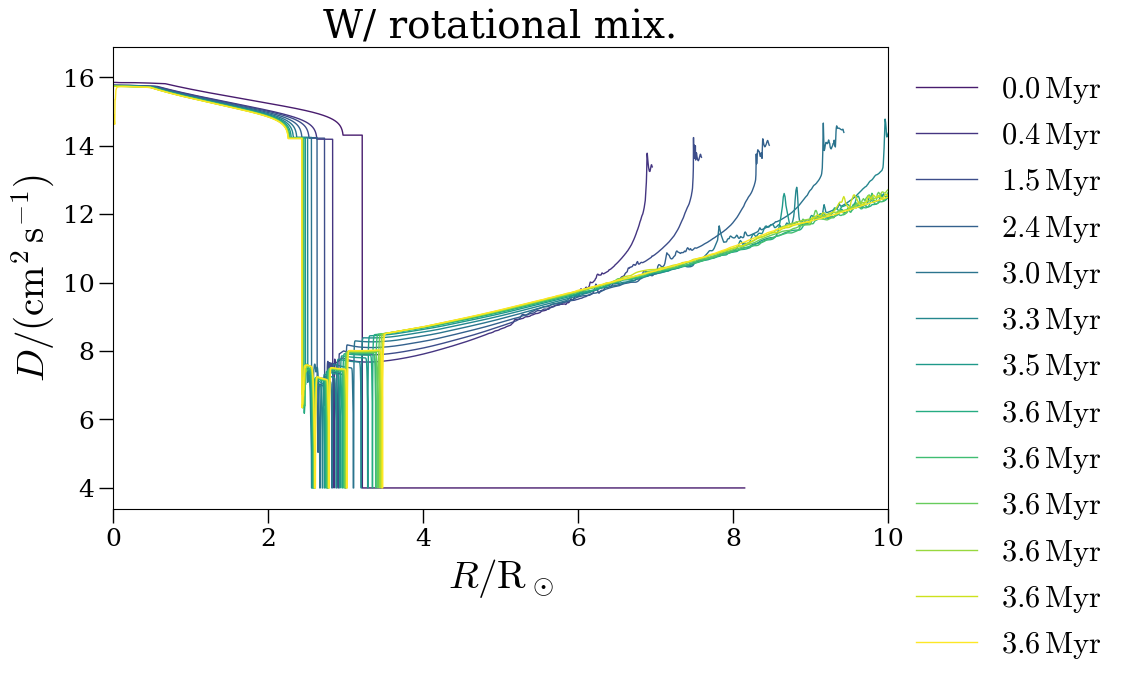

In [24]:
fig, ax = plt.subplots(figsize=(10,6))

for n in profile_numbers:
    c = cm.viridis(n/len(profile_numbers))
    prof = logs.profile_data(profile_number=n)
    ax.plot(prof.radius, prof.log_D_mix, c=c, label=f'${prof.star_age/1e6:.1f}\\,\\mathrm{{Myr}}$', lw=1)
    ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False)
    ax.set_title('W/ rotational mix.')
    ax.set_xlabel('$R/\\mathrm{R}_\\odot$')
    ax.set_ylabel('$D/(\\mathrm{cm}^2\\,\\mathrm{s}^{-1})$')
    ax.set_xlim(0,10)
    
    

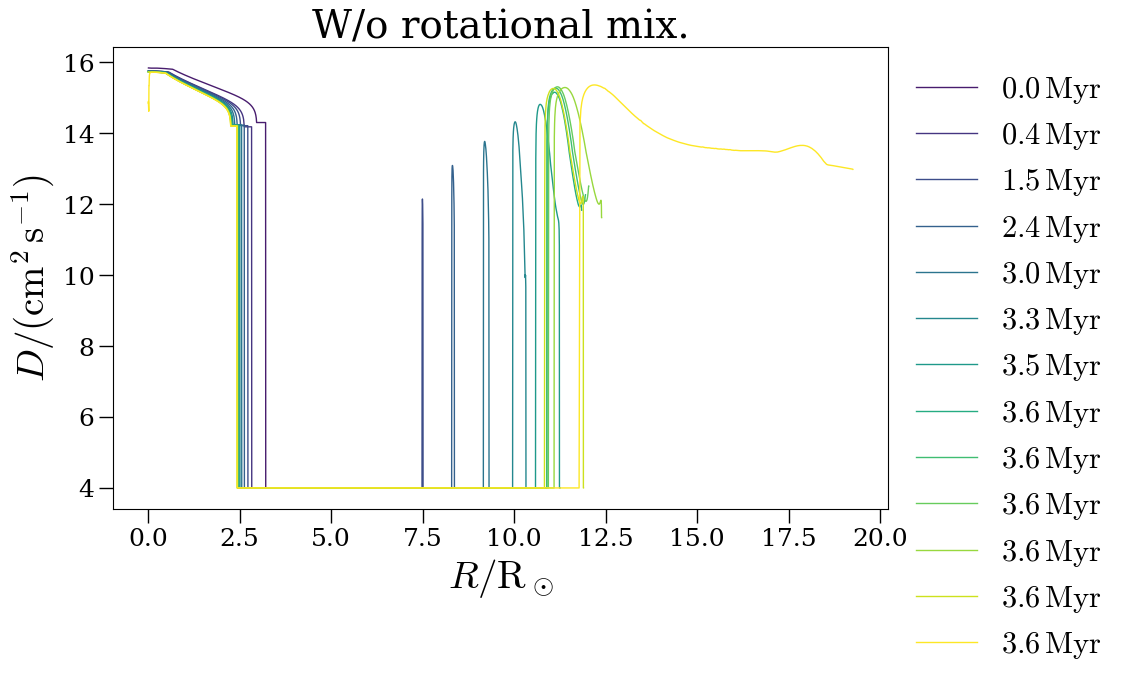

In [25]:
fig, ax = plt.subplots(figsize=(10,6))

for n in profile_numbers:
    c = cm.viridis(n/len(profile_numbers))
    prof = logs.profile_data(profile_number=n)
    ax.plot(prof.radius, prof.log_D_mix_non_rotation, c=c, label=f'${prof.star_age/1e6:.1f}\\,\\mathrm{{Myr}}$', lw=1)
    ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False)
    ax.set_title('W/o rotational mix.')
    ax.set_xlabel('$R/\\mathrm{R}_\\odot$')
    ax.set_ylabel('$D/(\\mathrm{cm}^2\\,\\mathrm{s}^{-1})$')
    
    

In [26]:
def tau_mix(prof):
    mix_types = prof.mixing_type
    first_overshoot_i = np.where(mix_types == 2)[0][0]

    r = prof.radius[:first_overshoot_i]
    d = 10.**prof.log_D_mix[:first_overshoot_i]
    d_nonrot = 10.**prof.log_D_mix_non_rotation[:first_overshoot_i]
    h_p = prof.pressure_scale_height[:first_overshoot_i] * u.Rsun.to(u.cm)
    dt_mix = h_p**2 / d
    dt_mix_nonrot = h_p**2 / d_nonrot

    mix_tscale = -simpson(x=r, y=dt_mix) * u.s.to(u.yr)
    mix_tscale_nonrot = -simpson(x=r, y=dt_mix_nonrot) * u.s.to(u.yr)

    return mix_tscale, mix_tscale_nonrot

In [27]:
all_paths = [model_dict[k1][k2] for k1 in model_dict.keys() for k2 in model_dict[k1].keys()] 

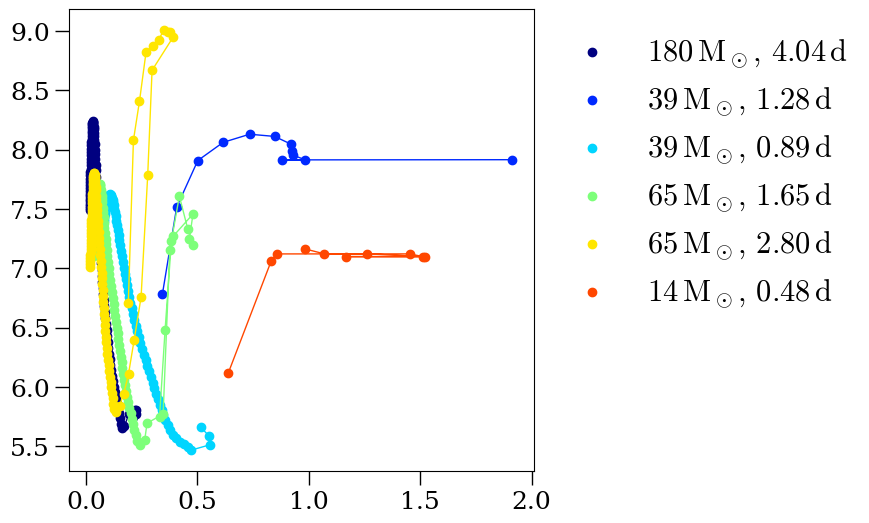

In [28]:

fig, ax = plt.subplots(figsize=(6,6))

_c = 0
handles = []
for m_key in model_dict.keys():
    p_dict = model_dict[m_key]
    m = float(m_key)
    for p_key in p_dict.keys():
        p = float(p_key)
        c = cm.jet(_c/len(all_paths))
        handles.append(ax.scatter([], [], marker='o', color=c, 
                                  label=f'${m:.0f}\\,\\mathrm{{M}}_\\odot,\\,{p:.2f}\\,\\mathrm{{d}}$'))
        p = float(p_key)
        model_path = p_dict[p_key]
        profiles = mr.MesaLogDir(model_path/'LOGS')
        plot_points = list()
        for n in profiles.profile_numbers:
            if n == 1:
                continue
            prof = profiles.profile_data(profile_number=n)
            tmix, tmix_nonrot = tau_mix(prof)
            plot_points.append([prof.omega_div_omega_crit[0], np.log10(tmix)])
        plot_points = np.array(plot_points)
        ax.plot(plot_points[:,0], plot_points[:,1], ls='-', marker='o', lw=1, color=c)
        _c += 1
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1,1))
#ax.set_xscale('log')

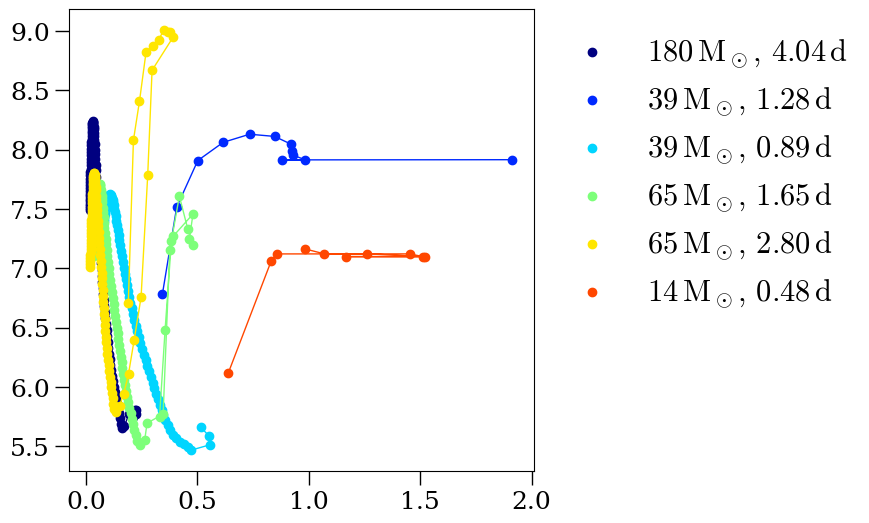

In [ ]:

fig, ax = plt.subplots(figsize=(6,6))

_c = 0
handles = []
for m_key in model_dict.keys():
    p_dict = model_dict[m_key]
    m = float(m_key)
    for p_key in p_dict.keys():
        p = float(p_key)
        c = cm.jet(_c/len(all_paths))
        handles.append(ax.scatter([], [], marker='o', color=c, 
                                  label=f'${m:.0f}\\,\\mathrm{{M}}_\\odot,\\,{p:.2f}\\,\\mathrm{{d}}$'))
        p = float(p_key)
        model_path = p_dict[p_key]
        profiles = mr.MesaLogDir(model_path/'LOGS')
        plot_points = list()
        for n in profiles.profile_numbers:
            if n == 1:
                continue
            prof = profiles.profile_data(profile_number=n)
            tmix, tmix_nonrot = tau_mix(prof)
            plot_points.append([prof.omega_div_omega_crit[0], np.log10(tmix)])
        plot_points = np.array(plot_points)
        ax.plot(plot_points[:,0], plot_points[:,1], ls='-', marker='o', lw=1, color=c)
        _c += 1
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1,1))
#ax.set_xscale('log')

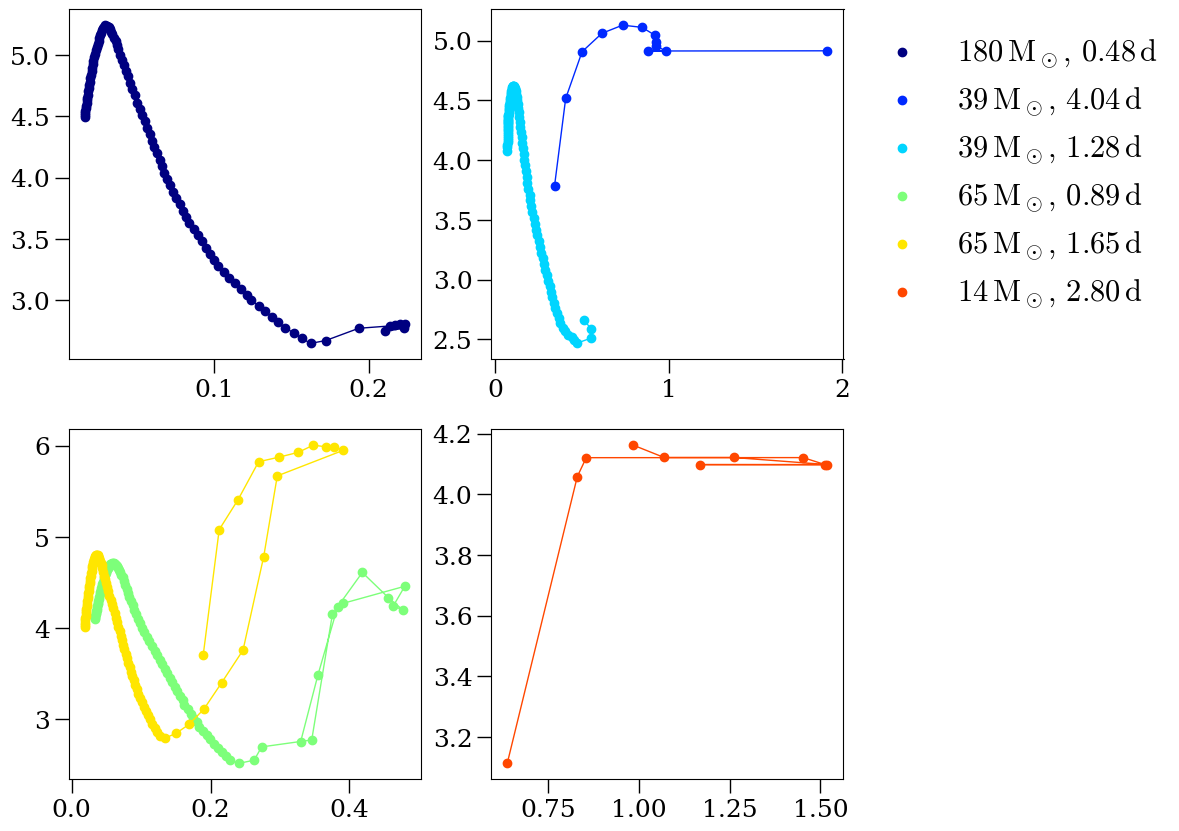

In [29]:

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

_c = 0
handles = []
for m_key, ax in zip(model_dict.keys(), axes.flatten()):
    p_dict = model_dict[m_key]
    m = float(m_key)
    for p_key in p_dict.keys():
        c = cm.jet(_c/len(all_paths))
        handles.append(ax.scatter([], [], marker='o', color=c, 
                                  label=f'${m:.0f}\\,\\mathrm{{M}}_\\odot,\\,{p:.2f}\\,\\mathrm{{d}}$'))
        p = float(p_key)
        model_path = p_dict[p_key]
        profiles = mr.MesaLogDir(model_path/'LOGS')
        plot_points = list()
        for n in profiles.profile_numbers:
            if n == 1:
                continue
            prof = profiles.profile_data(profile_number=n)
            tmix, tmix_nonrot = tau_mix(prof)
            plot_points.append([prof.omega_div_omega_crit[0], np.log10(tmix/1e3)])
        plot_points = np.array(plot_points)
        ax.plot(plot_points[:,0], plot_points[:,1], ls='-', marker='o', lw=1, color=c)
        _c += 1

#    ax.set_xscale('log')

axes[0, 1].legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1,1))


Text(0.5, 0, '$\\Omega/\\Omega_\\mathrm{c}$')

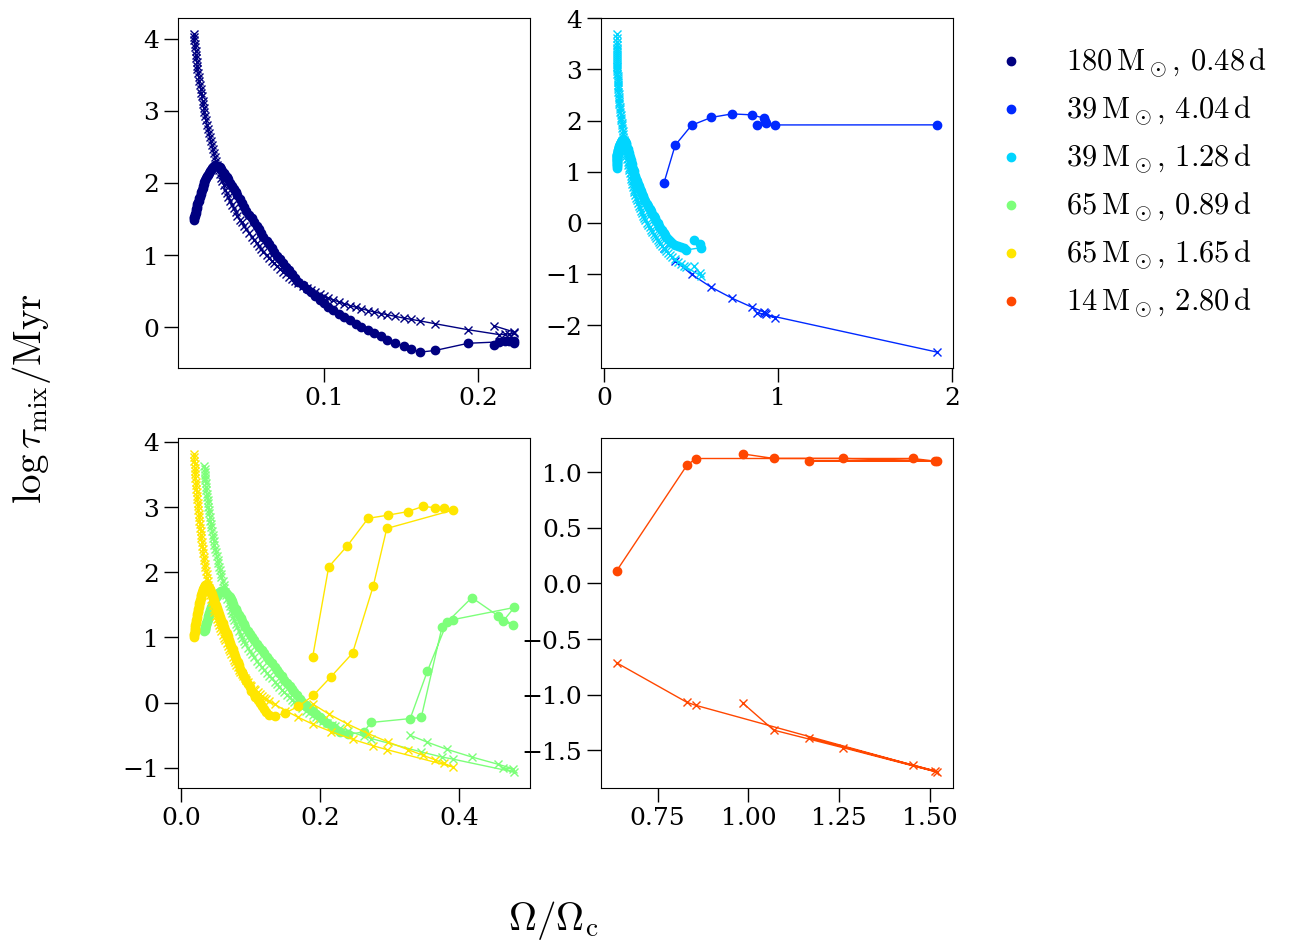

In [30]:

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

_c = 0
handles = []
for m_key, ax in zip(model_dict.keys(), axes.flatten()):
    p_dict = model_dict[m_key]
    m = float(m_key)
    for p_key in p_dict.keys():
        c = cm.jet(_c/len(all_paths))
        handles.append(ax.scatter([], [], marker='o', color=c, 
                                  label=f'${m:.0f}\\,\\mathrm{{M}}_\\odot,\\,{p:.2f}\\,\\mathrm{{d}}$'))
        p = float(p_key)
        model_path = p_dict[p_key]
        profiles = mr.MesaLogDir(model_path/'LOGS')
        plot_points = list()
        es_plot_points = list()
        for n in profiles.profile_numbers:
            if n == 1:
                continue
            prof = profiles.profile_data(profile_number=n)
            tmix, tmix_nonrot = tau_mix(prof)
            plot_points.append([prof.omega_div_omega_crit[0], np.log10(tmix/1e6)])
            
            analytical_es_t = tau_es1(m=prof.mass[0],
                                      r=prof.radius[0],
                                      tau_kh=prof.kh_timescale,
                                      omega=prof.omega[0])
            es_plot_points.append([prof.omega_div_omega_crit[0], np.log10(analytical_es_t/1e6)])
            
            
        plot_points = np.array(plot_points)
        es_plot_points = np.array(es_plot_points)        
        ax.plot(plot_points[:,0], plot_points[:,1], ls='-', marker='o', lw=1, color=c)
        ax.plot(es_plot_points[:,0], es_plot_points[:,1], ls='-', marker='x', lw=1, color=c)
        
        
        _c += 1

#    ax.set_xscale('log')

axes[0, 1].legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1,1))
fig.text(0, 0.5, '$\\log\\tau_\\mathrm{mix}/\\mathrm{Myr}$', va='center', ha='right', rotation=90)
fig.text(0.5, 0, '$\\Omega/\\Omega_\\mathrm{c}$', ha='center', va='top')

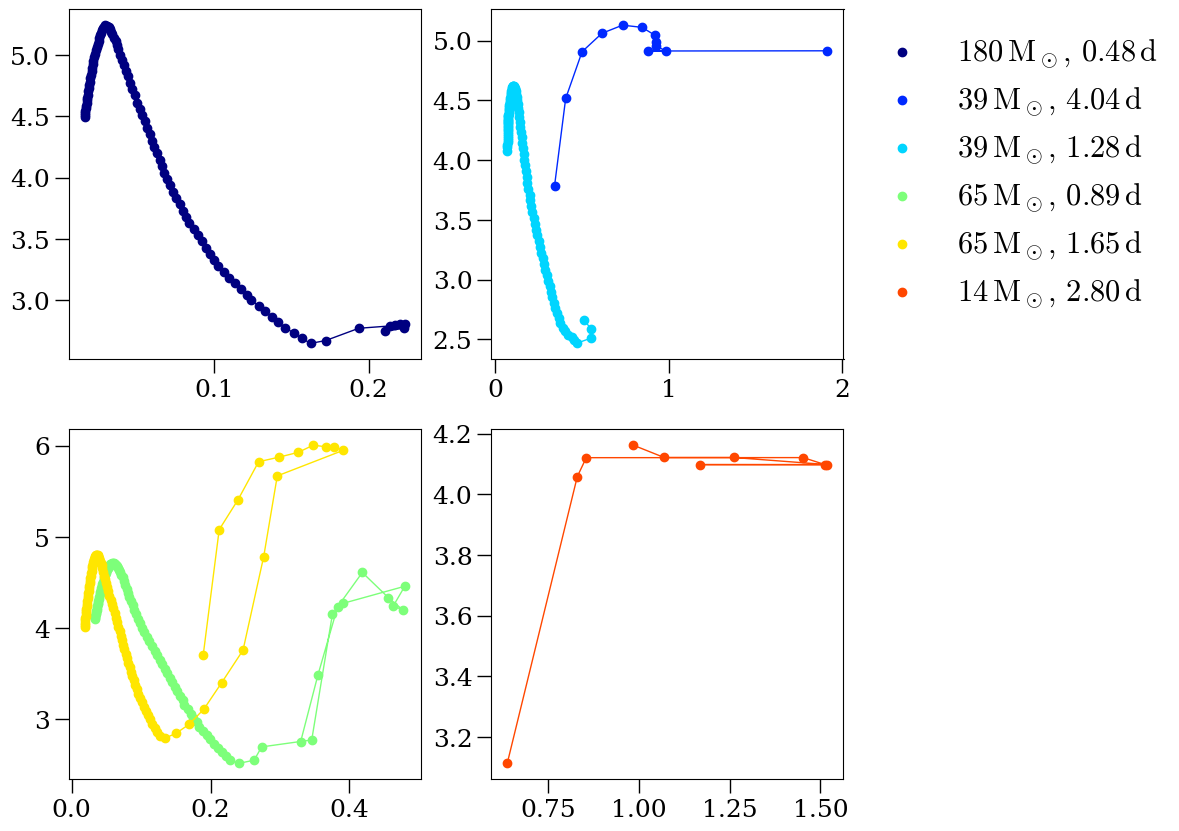

In [31]:

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

_c = 0
handles = []
for m_key, ax in zip(model_dict.keys(), axes.flatten()):
    p_dict = model_dict[m_key]
    m = float(m_key)
    for p_key in p_dict.keys():
        c = cm.jet(_c/len(all_paths))
        handles.append(ax.scatter([], [], marker='o', color=c, 
                                  label=f'${m:.0f}\\,\\mathrm{{M}}_\\odot,\\,{p:.2f}\\,\\mathrm{{d}}$'))
        p = float(p_key)
        model_path = p_dict[p_key]
        profiles = mr.MesaLogDir(model_path/'LOGS')
        plot_points = list()
        for n in profiles.profile_numbers:
            if n == 1:
                continue
            prof = profiles.profile_data(profile_number=n)
            tmix, tmix_nonrot = tau_mix(prof)
            plot_points.append([prof.omega_div_omega_crit[0], np.log10(tmix/1e3)])
        plot_points = np.array(plot_points)
        ax.plot(plot_points[:,0], plot_points[:,1], ls='-', marker='o', lw=1, color=c)
        _c += 1

#    ax.set_xscale('log')

axes[0, 1].legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1,1))


Text(0, 0.5, '$\\tau_\\mathrm{mix}/\\mathrm{Myr}$')

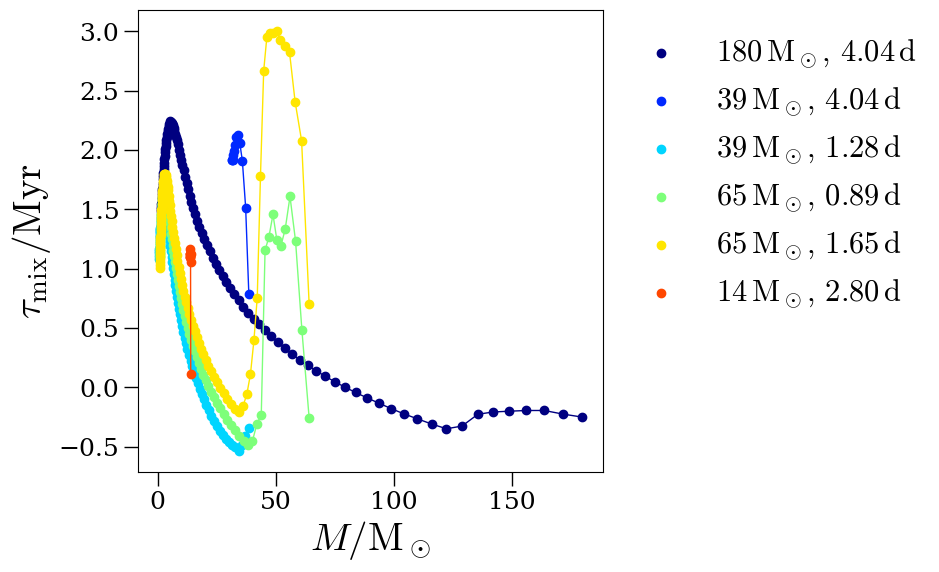

In [37]:

fig, ax = plt.subplots(figsize=(6,6))

_c = 0
handles = []
for m_key in model_dict.keys():
    p_dict = model_dict[m_key]
    m = float(m_key)
    for p_key in p_dict.keys():
        c = cm.jet(_c/len(all_paths))
        handles.append(ax.scatter([], [], marker='o', color=c, 
                                  label=f'${m:.0f}\\,\\mathrm{{M}}_\\odot,\\,{p:.2f}\\,\\mathrm{{d}}$'))
        p = float(p_key)
        model_path = p_dict[p_key]
        profiles = mr.MesaLogDir(model_path/'LOGS')
        plot_points = list()
        for n in profiles.profile_numbers:
            if n == 1:
                continue
            prof = profiles.profile_data(profile_number=n)
            tmix, tmix_nonrot = tau_mix(prof)
            plot_points.append([prof.mass[0], np.log10(tmix/1e6)])
        plot_points = np.array(plot_points)
        ax.plot(plot_points[:,0], plot_points[:,1], ls='-', marker='o', lw=1, color=c)
        _c += 1
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1,1))
#ax.set_xscale('log')
ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
ax.set_ylabel('$\\tau_\\mathrm{mix}/\\mathrm{Myr}$')

Text(0, 0.5, '$\\tau_\\mathrm{mix}/\\mathrm{Myr}$')

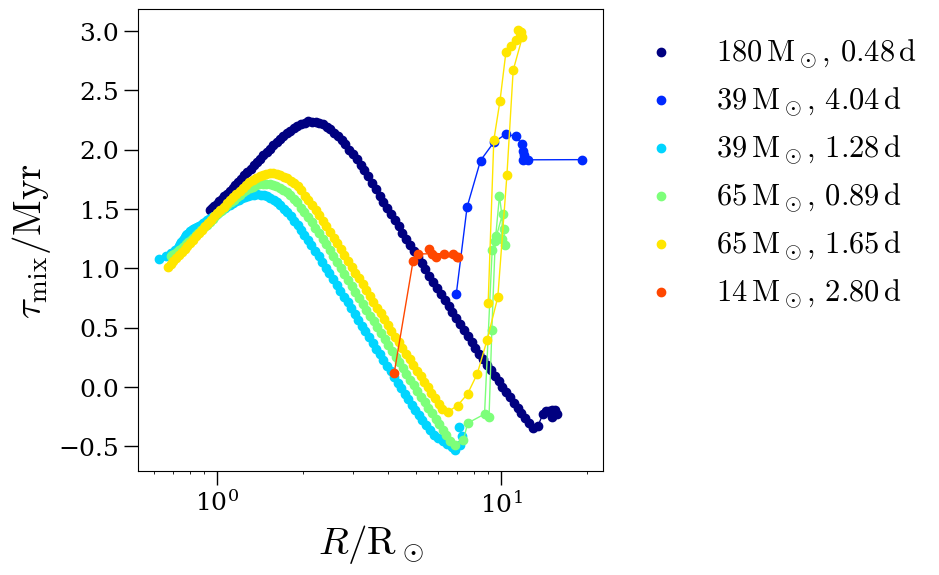

In [38]:
fig, ax = plt.subplots(figsize=(6,6))

_c = 0
handles = []
for m_key in model_dict.keys():
    p_dict = model_dict[m_key]
    m = float(m_key)
    for p_key in p_dict.keys():
        c = cm.jet(_c/len(all_paths))
        handles.append(ax.scatter([], [], marker='o', color=c, 
                                  label=f'${m:.0f}\\,\\mathrm{{M}}_\\odot,\\,{p:.2f}\\,\\mathrm{{d}}$'))
        p = float(p_key)
        model_path = p_dict[p_key]
        profiles = mr.MesaLogDir(model_path/'LOGS')
        plot_points = list()
        for n in profiles.profile_numbers:
            if n == 1:
                continue
            prof = profiles.profile_data(profile_number=n)
            tmix, tmix_nonrot = tau_mix(prof)
            plot_points.append([prof.radius[0], np.log10(tmix/1e6)])
        plot_points = np.array(plot_points)
        ax.plot(plot_points[:,0], plot_points[:,1], ls='-', marker='o', lw=1, color=c)
        _c += 1
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1,1))
ax.set_xscale('log')
ax.set_xlabel('$R/\\mathrm{R}_\\odot$')
ax.set_ylabel('$\\tau_\\mathrm{mix}/\\mathrm{Myr}$')

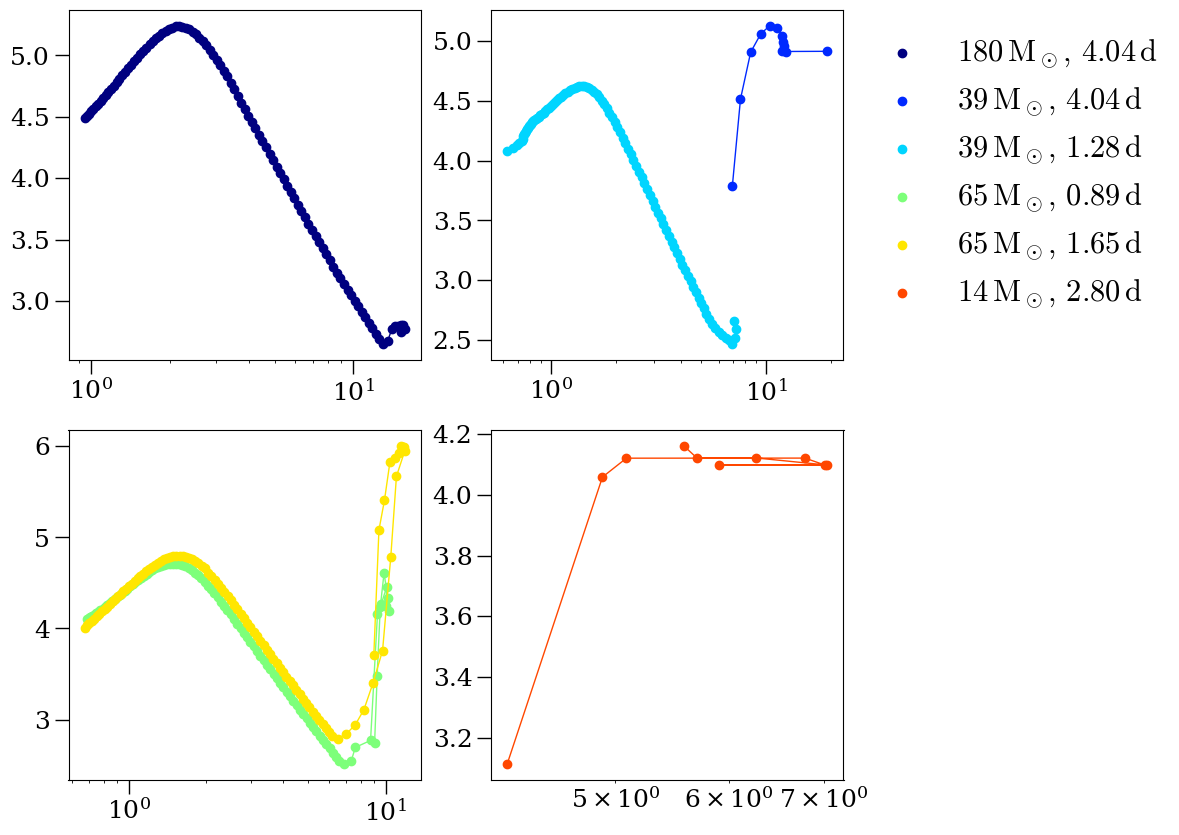

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

_c = 0
handles = []
for m_key, ax in zip(model_dict.keys(), axes.flatten()):
    p_dict = model_dict[m_key]
    m = float(m_key)
    for p_key in p_dict.keys():
        c = cm.jet(_c/len(all_paths))
        handles.append(ax.scatter([], [], marker='o', color=c, 
                                  label=f'${m:.0f}\\,\\mathrm{{M}}_\\odot,\\,{p:.2f}\\,\\mathrm{{d}}$'))
        p = float(p_key)
        model_path = p_dict[p_key]
        profiles = mr.MesaLogDir(model_path/'LOGS')
        plot_points = list()
        for n in profiles.profile_numbers:
            if n == 1:
                continue
            prof = profiles.profile_data(profile_number=n)
            tmix, tmix_nonrot = tau_mix(prof)
            plot_points.append([prof.radius[0], np.log10(tmix/1e3)])
        plot_points = np.array(plot_points)
        ax.plot(plot_points[:,0], plot_points[:,1], ls='-', marker='o', lw=1, color=c)
        _c += 1

    ax.set_xscale('log')

axes[0, 1].legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1,1))


Text(0.5, 0, '$R/\\mathrm{R}_\\odot$')

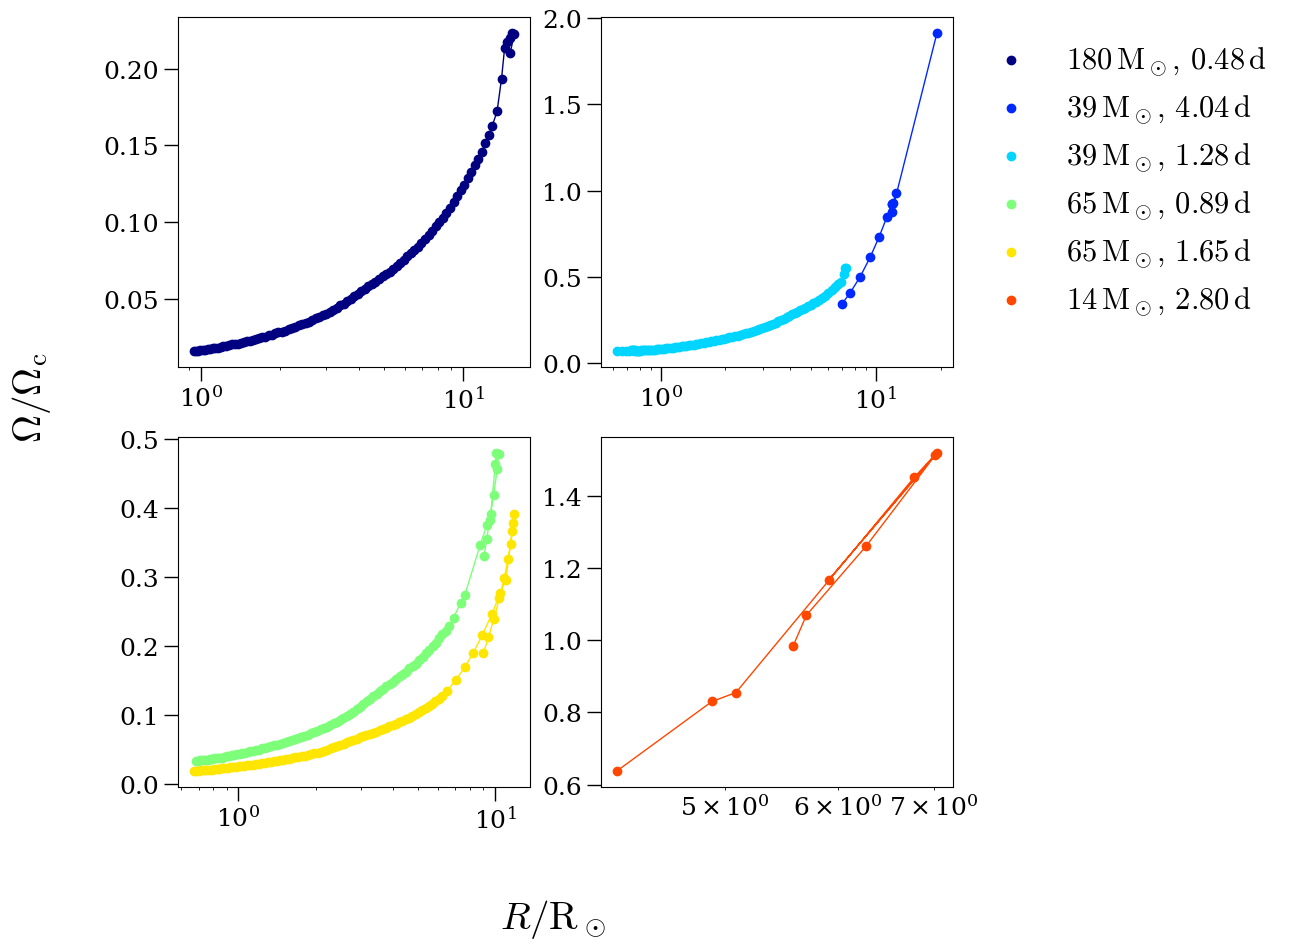

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

_c = 0
handles = []
for m_key, ax in zip(model_dict.keys(), axes.flatten()):
    p_dict = model_dict[m_key]
    m = float(m_key)
    for p_key in p_dict.keys():
        c = cm.jet(_c/len(all_paths))
        handles.append(ax.scatter([], [], marker='o', color=c, 
                                  label=f'${m:.0f}\\,\\mathrm{{M}}_\\odot,\\,{p:.2f}\\,\\mathrm{{d}}$'))
        p = float(p_key)
        model_path = p_dict[p_key]
        profiles = mr.MesaLogDir(model_path/'LOGS')
        plot_points = list()
        for n in profiles.profile_numbers:
            if n == 1:
                continue
            prof = profiles.profile_data(profile_number=n)
            tmix, tmix_nonrot = tau_mix(prof)
            plot_points.append([prof.radius[0], prof.omega_div_omega_crit[0]])
        plot_points = np.array(plot_points)
        ax.plot(plot_points[:,0], plot_points[:,1], ls='-', marker='o', lw=1, color=c)
        _c += 1

    ax.set_xscale('log')

axes[0, 1].legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1,1))
fig.text(0, 0.5, '$\\Omega/\\Omega_\\mathrm{c}$', va='center', ha='right', rotation=90)
fig.text(0.5, 0, '$R/\\mathrm{R}_\\odot$', ha='center', va='top')
